## Ref: https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo

In [3]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import gc

- `[training/test]_set_metadata`: Information about objects in the that doesn't change over time, like the coordinates of the object.
- `[training/test]_set`: Time series of observations of the objects. Maps to the metadata via object_id.

In [4]:
train = pd.read_csv("training_set.csv")
train_meta = pd.read_csv("training_set_metadata.csv")

### Metadata File Column Descriptions

In [5]:
train_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


- `object_id`: unique object identifier. Int32
- `ra`: right ascension, sky coordinate: co-longitude in degrees. Float32
- `decl`: declination, sky coordinate: co-latitude in degrees. Float32
- `gal_l`: galactic longitude in degrees. Float32
- `gal_b`: galactic latitude in degrees. Float32
- `ddf`: A flag to identify the object as coming from the DDF survey area (with value DDF = 1 for the DDF, DDF = 0 for the WFD survey). Note that while the - DDF fields are contained within the full WFD survey area, the DDF fluxes have significantly smaller uncertainties. Boolean
- `hostgal_specz`: the spectroscopic redshift of the source. This is an extremely accurate measure of redshift, available for the training set and a small fraction of the test set. Float32 (적색편이)
- `hostgal_photoz`: The photometric redshift of the host galaxy of the astronomical source. While this is meant to be a proxy for hostgal_specz, there can be large differences between the two and should be regarded as a far less accurate version of hostgal_specz. Float32
- `hostgal_photoz_err`: The uncertainty on the hostgal_photoz based on LSST survey projections. Float32
- `distmod`: The distance to the source calculated from hostgal_photoz and using general relativity. Float32
- `mwebv`: MW E(B-V). this ‘extinction’ of light is a property of the Milky Way (MW) dust along the line of sight to the astronomical source, and is thus a function of the sky coordinates of the source ra, decl. This is used to determine a passband dependent dimming and redenning of light from astronomical sources as described in subsection 2.1, and based on the Schlafly et al. (2011) and Schlegel et al. (1998) dust models. Float32
- `target`: The class of the astronomical source. This is provided in the training data. Correctly determining the target (correctly assigning classification probabilities to the objects) is the ‘goal’ of the classification challenge for the test data. Note that there is one class in the test set that does not occur in the training set: class_99 serves as an "other" class for objects that don't belong in any of the 14 classes in the training set. Int8

In [6]:
print("unique values of object_id:",len(train_meta['object_id'].unique()),"\nshape of train_meta:",train_meta.shape[0])

unique values of object_id: 7848 
shape of train_meta: 7848


Text(0,0.5,'Percent of Missing Value (%)')

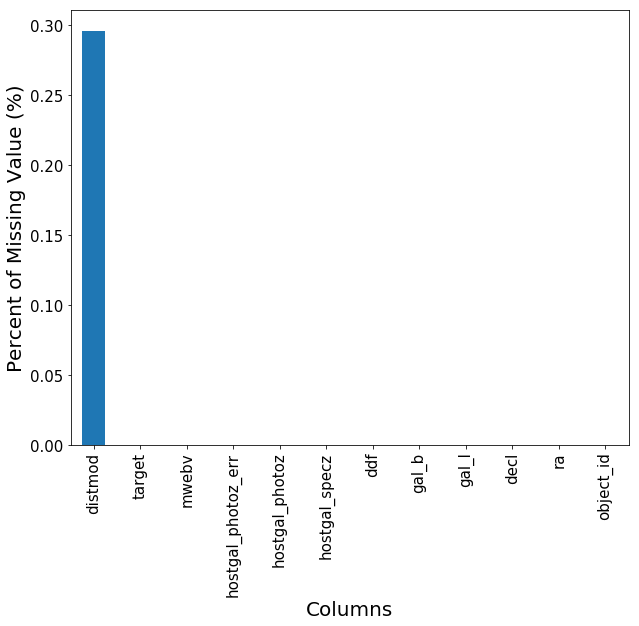

In [7]:
#missing data
total = train_meta.isnull().sum().sort_values(ascending=False)
percent = (train_meta.isnull().sum()/train_meta.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

#histogram
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (10,8), fontsize = 15)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Percent of Missing Value (%)", fontsize = 20)
#plt.title("Total Missing Value (%)", fontsize = 20)

In [8]:
train.shape

(1421705, 6)

In [9]:
train_meta[train_meta['distmod'].isnull()].head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,NaN,0.020,65
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0,0.0,0.0,NaN,0.018,65
14,2624,346.655182,-63.260487,320.952196,-50.040935,1,0.0,0.0,0.0,NaN,0.019,65
15,2677,53.964844,-28.630989,225.142950,-53.813613,1,0.0,0.0,0.0,NaN,0.009,16


In [10]:
pd.isna(train_meta['distmod'].iloc[0])

True

In [11]:
train_meta['Milky.Way'] = train_meta["distmod"].apply(lambda x: 1 if pd.isnull(x) == True else 0)

In [12]:
train_meta.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,Milky.Way
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92,1
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88,0
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42,0
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90,0
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90,0


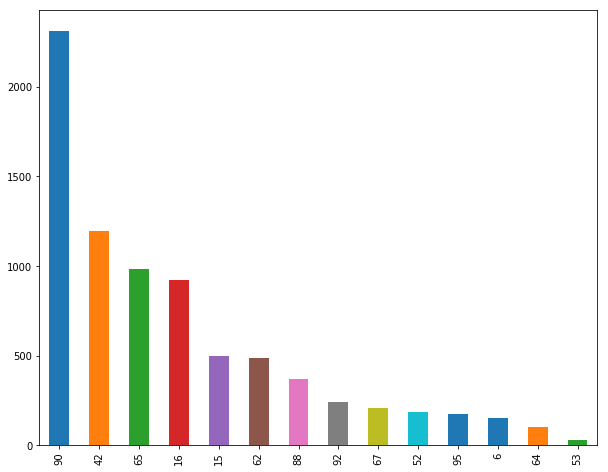

In [13]:
f, ax = plt.subplots(figsize=(10,8))
train_meta['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.show()

Target value is uneven. it seems class imbalance. I wonder if I should use sampling here.

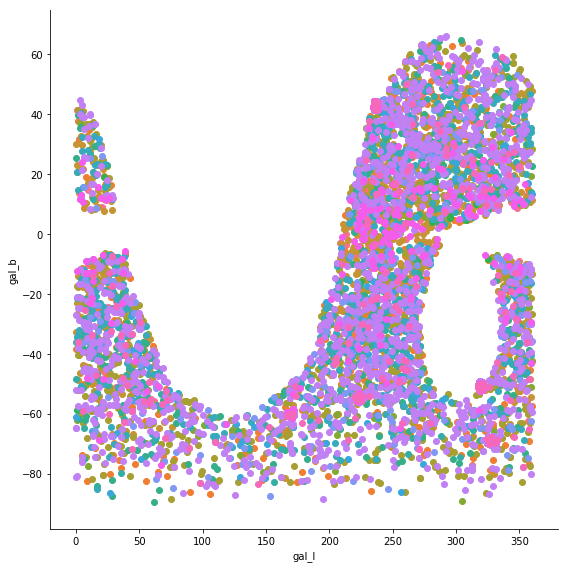

In [14]:
g = sns.FacetGrid(train_meta, hue = 'target',size=8)
g.map(plt.scatter, 'gal_l','gal_b')

Whale...?

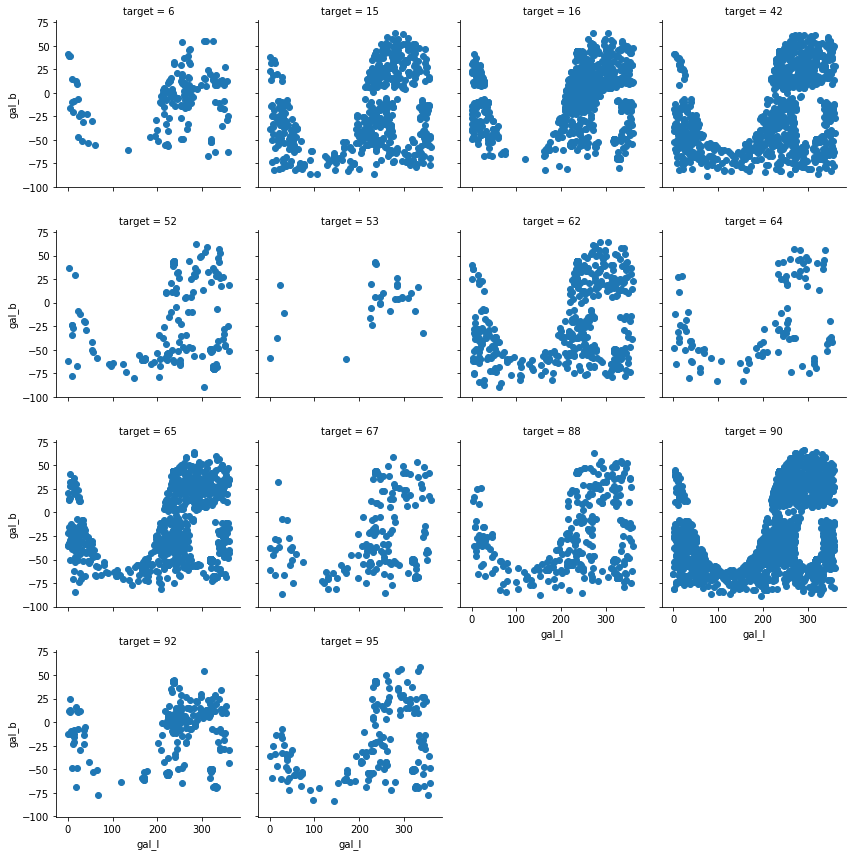

In [15]:
g = sns.FacetGrid(train_meta, col = 'target',col_wrap=4)
g.map(plt.scatter, 'gal_l','gal_b')

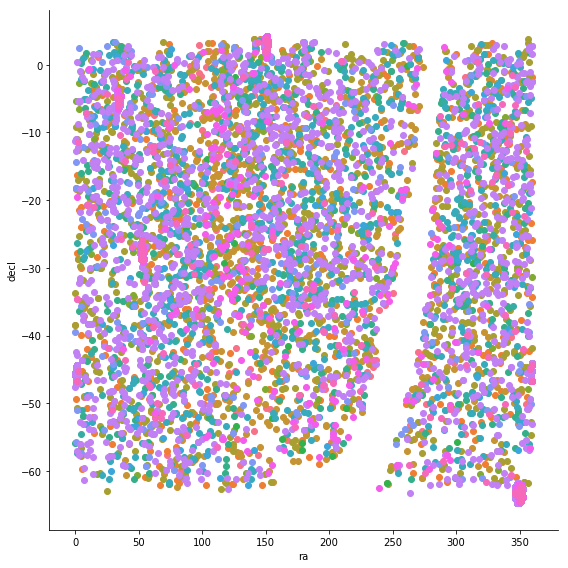

In [16]:
g = sns.FacetGrid(train_meta, hue = 'target',size=8)
g.map(plt.scatter, 'ra','decl')

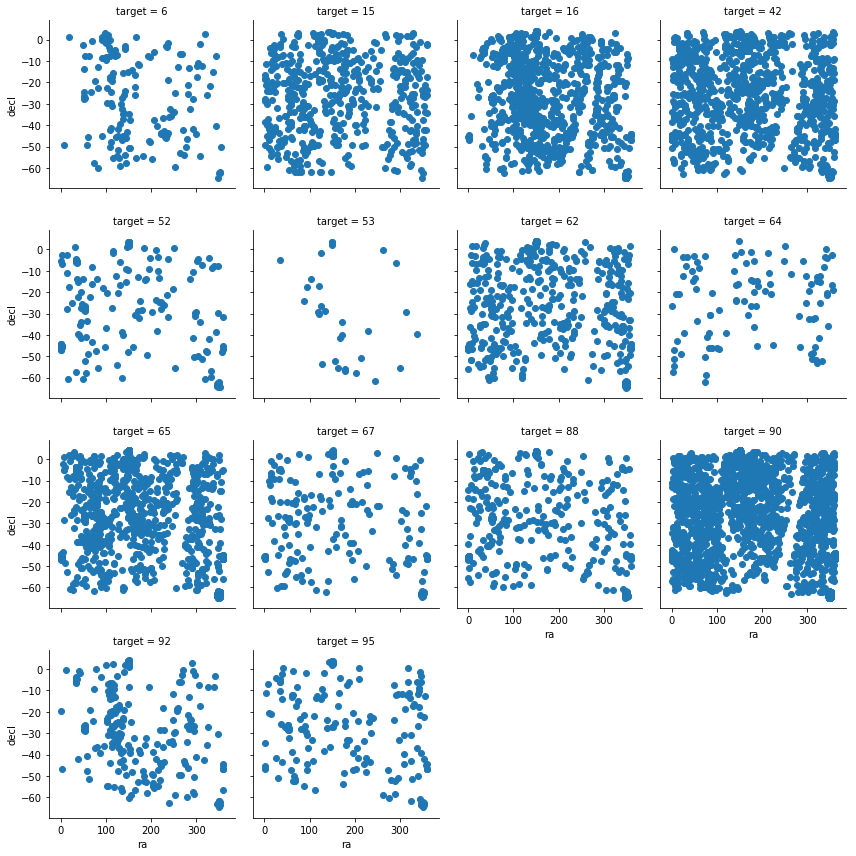

In [17]:
g = sns.FacetGrid(train_meta, col = 'target',col_wrap=4)
g.map(plt.scatter, 'ra','decl')

In [18]:
np.sin(349.046051 * np.pi / 180)

-0.1900199592527963

In [19]:
train_meta['skycoordinate_x'] = train_meta["distmod"] * train_meta["decl"].apply(lambda x: np.sin(x * np.pi/180)) * train_meta["ra"].apply(lambda x: np.cos(x * np.pi/180))
train_meta['skycoordinate_y'] = train_meta["distmod"] * train_meta["decl"].apply(lambda x: np.sin(x * np.pi/180)) * train_meta["ra"].apply(lambda x: np.sin(x * np.pi/180))
train_meta['skycoordinate_z'] = train_meta["distmod"] * train_meta["decl"].apply(lambda x: np.cos(x * np.pi/180))

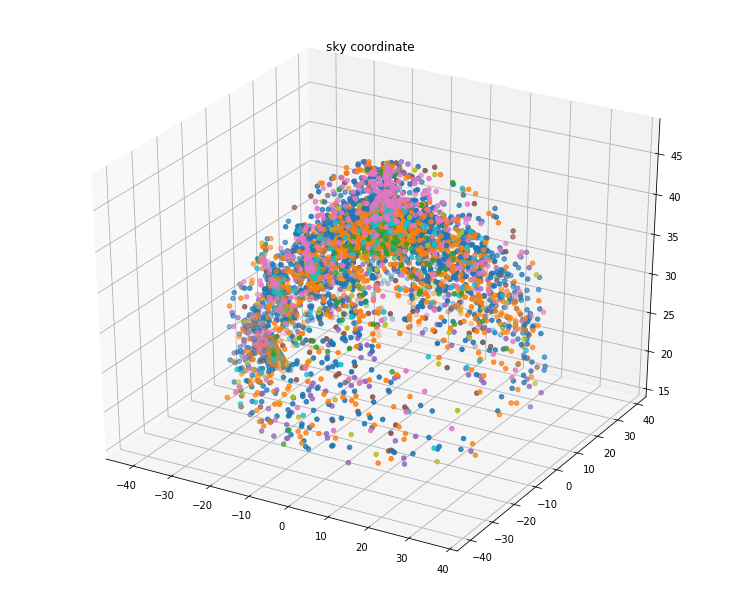

In [20]:
#https://matplotlib.org/examples/mplot3d/scatter3d_demo.html
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

#ax.scatter(swasp_mag1,swasp_per1,swasp_age1,edgecolor='none',c='r',marker='o',s=35,label='SWASP')
#ax.scatter(hyd_mag1,hyd_per1,hyd_age1,edgecolor='none',c='y',marker='o',s=35,label='Hyades')
#ax.scatter(pld_mag1,pld_per1,pld_age1,edgecolor='none',c='b',marker='o',s=35,label='Pleiades')

ax.scatter(train_meta[train_meta['target']==90]['skycoordinate_x'], train_meta[train_meta['target']==90]['skycoordinate_y'], train_meta[train_meta['target']==90]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==42]['skycoordinate_x'], train_meta[train_meta['target']==42]['skycoordinate_y'], train_meta[train_meta['target']==42]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==65]['skycoordinate_x'], train_meta[train_meta['target']==65]['skycoordinate_y'], train_meta[train_meta['target']==65]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==16]['skycoordinate_x'], train_meta[train_meta['target']==16]['skycoordinate_y'], train_meta[train_meta['target']==16]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==15]['skycoordinate_x'], train_meta[train_meta['target']==15]['skycoordinate_y'], train_meta[train_meta['target']==15]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==62]['skycoordinate_x'], train_meta[train_meta['target']==62]['skycoordinate_y'], train_meta[train_meta['target']==62]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==88]['skycoordinate_x'], train_meta[train_meta['target']==88]['skycoordinate_y'], train_meta[train_meta['target']==88]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==92]['skycoordinate_x'], train_meta[train_meta['target']==92]['skycoordinate_y'], train_meta[train_meta['target']==92]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==67]['skycoordinate_x'], train_meta[train_meta['target']==67]['skycoordinate_y'], train_meta[train_meta['target']==67]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==52]['skycoordinate_x'], train_meta[train_meta['target']==52]['skycoordinate_y'], train_meta[train_meta['target']==52]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==95]['skycoordinate_x'], train_meta[train_meta['target']==95]['skycoordinate_y'], train_meta[train_meta['target']==95]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==6]['skycoordinate_x'], train_meta[train_meta['target']==6]['skycoordinate_y'], train_meta[train_meta['target']==6]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==64]['skycoordinate_x'], train_meta[train_meta['target']==64]['skycoordinate_y'], train_meta[train_meta['target']==64]['skycoordinate_z'])
ax.scatter(train_meta[train_meta['target']==53]['skycoordinate_x'], train_meta[train_meta['target']==53]['skycoordinate_y'], train_meta[train_meta['target']==53]['skycoordinate_z'])

plt.title("sky coordinate")
plt.show()

In [21]:
train_meta['galatic_x'] = train_meta["distmod"] * train_meta["gal_b"].apply(lambda x: np.sin(x * np.pi/180)) * train_meta["gal_l"].apply(lambda x: np.cos(x * np.pi/180))
train_meta['galatic_y'] = train_meta["distmod"] * train_meta["gal_b"].apply(lambda x: np.sin(x * np.pi/180)) * train_meta["gal_l"].apply(lambda x: np.sin(x * np.pi/180))
train_meta['galatic_z'] = train_meta["distmod"] * train_meta["gal_b"].apply(lambda x: np.cos(x * np.pi/180))

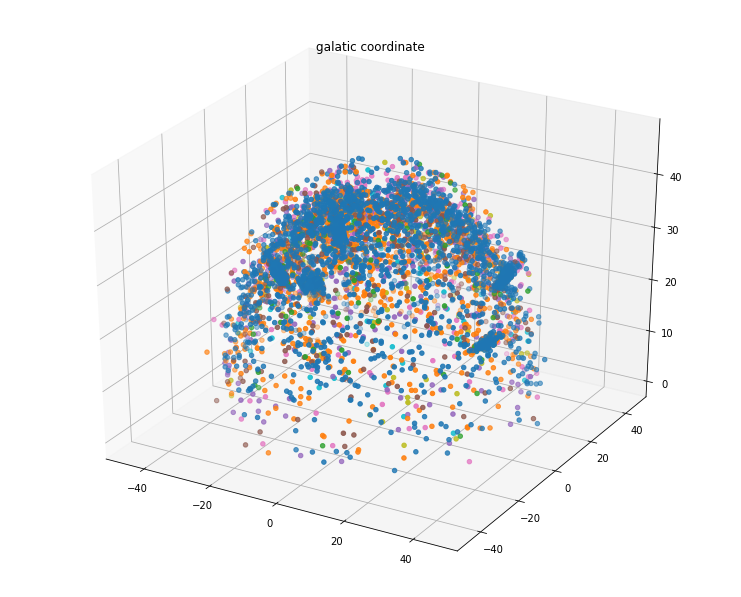

In [22]:
#https://matplotlib.org/examples/mplot3d/scatter3d_demo.html

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

#ax.scatter(swasp_mag1,swasp_per1,swasp_age1,edgecolor='none',c='r',marker='o',s=35,label='SWASP')
#ax.scatter(hyd_mag1,hyd_per1,hyd_age1,edgecolor='none',c='y',marker='o',s=35,label='Hyades')
#ax.scatter(pld_mag1,pld_per1,pld_age1,edgecolor='none',c='b',marker='o',s=35,label='Pleiades')

ax.scatter(train_meta[train_meta['target']==90]['galatic_x'], train_meta[train_meta['target']==90]['galatic_y'], train_meta[train_meta['target']==90]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==42]['galatic_x'], train_meta[train_meta['target']==42]['galatic_y'], train_meta[train_meta['target']==42]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==65]['galatic_x'], train_meta[train_meta['target']==65]['galatic_y'], train_meta[train_meta['target']==65]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==16]['galatic_x'], train_meta[train_meta['target']==16]['galatic_y'], train_meta[train_meta['target']==16]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==15]['galatic_x'], train_meta[train_meta['target']==15]['galatic_y'], train_meta[train_meta['target']==15]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==62]['galatic_x'], train_meta[train_meta['target']==62]['galatic_y'], train_meta[train_meta['target']==62]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==88]['galatic_x'], train_meta[train_meta['target']==88]['galatic_y'], train_meta[train_meta['target']==88]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==92]['galatic_x'], train_meta[train_meta['target']==92]['galatic_y'], train_meta[train_meta['target']==92]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==67]['galatic_x'], train_meta[train_meta['target']==67]['galatic_y'], train_meta[train_meta['target']==67]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==52]['galatic_x'], train_meta[train_meta['target']==52]['galatic_y'], train_meta[train_meta['target']==52]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==95]['galatic_x'], train_meta[train_meta['target']==95]['galatic_y'], train_meta[train_meta['target']==95]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==6]['galatic_x'], train_meta[train_meta['target']==6]['galatic_y'], train_meta[train_meta['target']==6]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==64]['galatic_x'], train_meta[train_meta['target']==64]['galatic_y'], train_meta[train_meta['target']==64]['galatic_z'])
ax.scatter(train_meta[train_meta['target']==53]['galatic_x'], train_meta[train_meta['target']==53]['galatic_y'], train_meta[train_meta['target']==53]['galatic_z'])

plt.title("galatic coordinate")
plt.show()

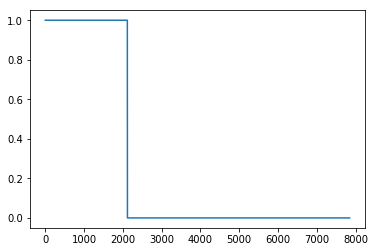

In [23]:
train_meta['ddf'].plot()

hmm...?

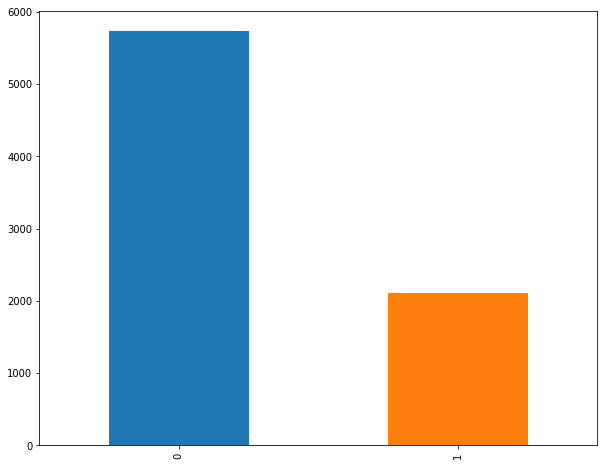

In [24]:
f, ax = plt.subplots(figsize=(10,8))
train_meta['ddf'].value_counts().sort_values(ascending=False).plot.bar()
plt.show()

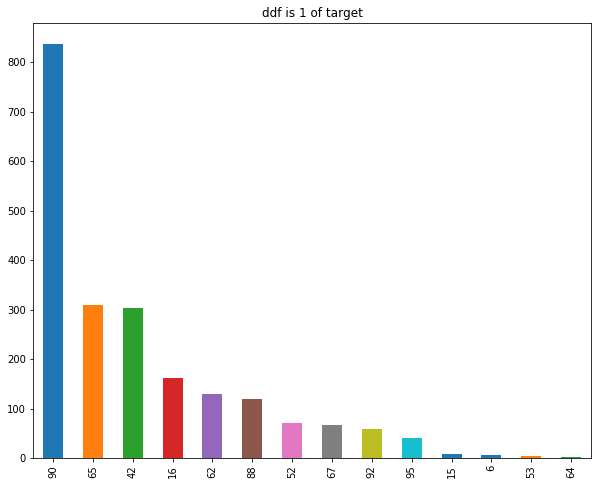

In [25]:
f, ax = plt.subplots(figsize=(10,8))
train_meta[train_meta['ddf']==1]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title("ddf is 1 of target")
plt.show()

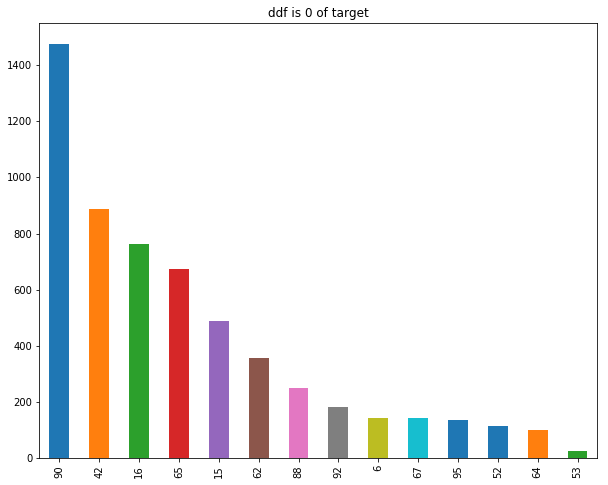

In [26]:
f, ax = plt.subplots(figsize=(10,8))
train_meta[train_meta['ddf']==0]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title("ddf is 0 of target")
plt.show()

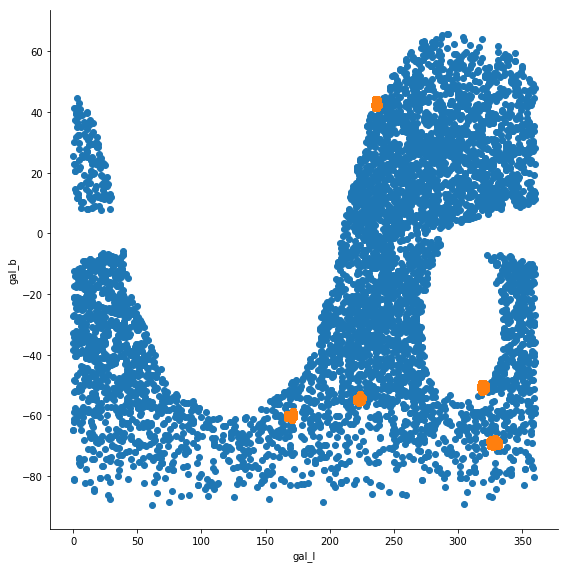

In [27]:
g = sns.FacetGrid(train_meta, hue = 'ddf',size=8)
g.map(plt.scatter, 'gal_l','gal_b')

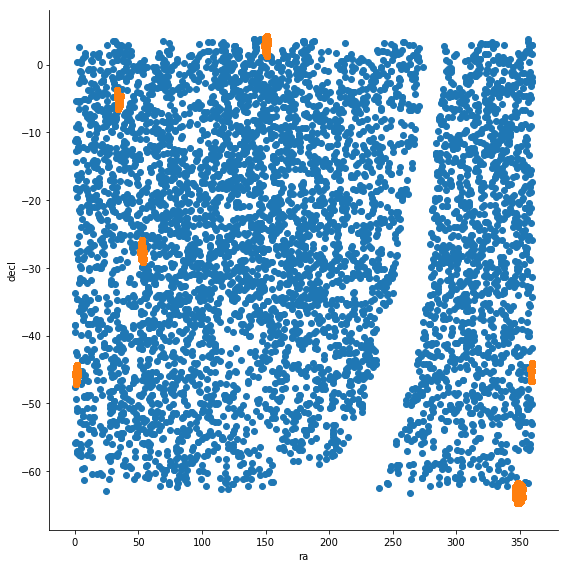

In [28]:
g = sns.FacetGrid(train_meta, hue = 'ddf',size=8)
g.map(plt.scatter, 'ra','decl')

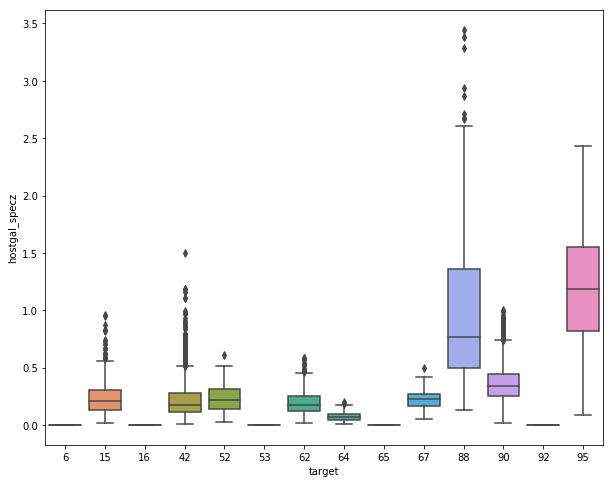

In [29]:
f, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x='target', y="hostgal_specz", data=train_meta)

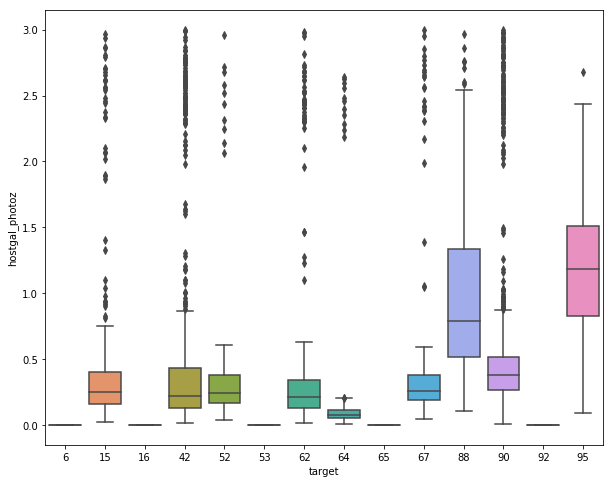

In [30]:
f, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x='target', y="hostgal_photoz", data=train_meta)

Text(0.5,1,'Photometric Redshift')

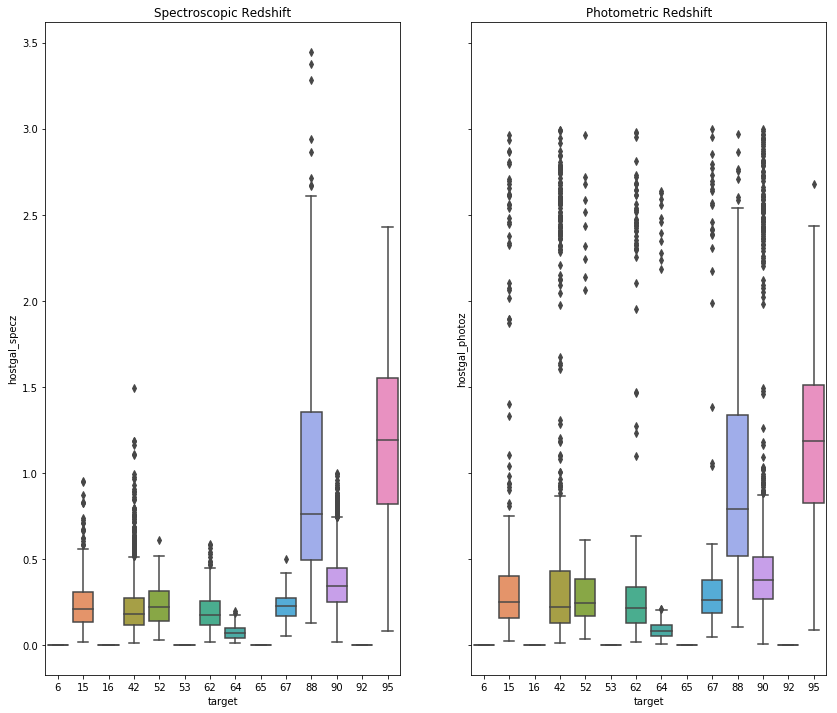

In [31]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,12),sharey=True)
sns.boxplot(x='target', y="hostgal_specz", data=train_meta,ax=axis1)
axis1.set_title('Spectroscopic Redshift')
sns.boxplot(x='target', y="hostgal_photoz", data=train_meta,ax=axis2)
axis2.set_title('Photometric Redshift')

Photometric seems to more outliers

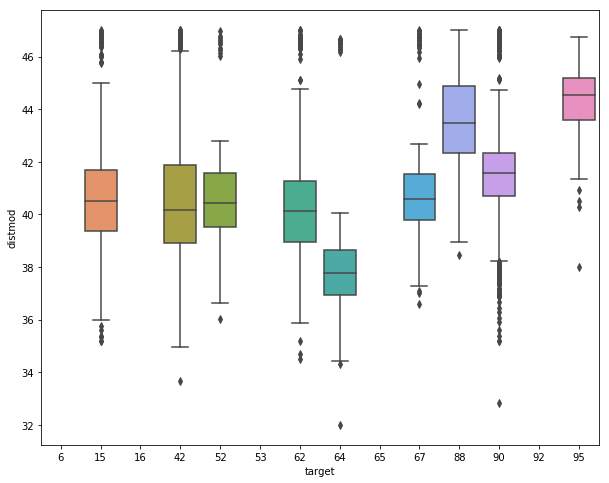

In [32]:
f, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x='target', y="distmod", data=train_meta)

target 6, 16, 53, 65, 92 has no distmod 

In [33]:
train_meta[train_meta['distmod'].isnull()]['target'].unique()

array([92, 65, 16,  6, 53])

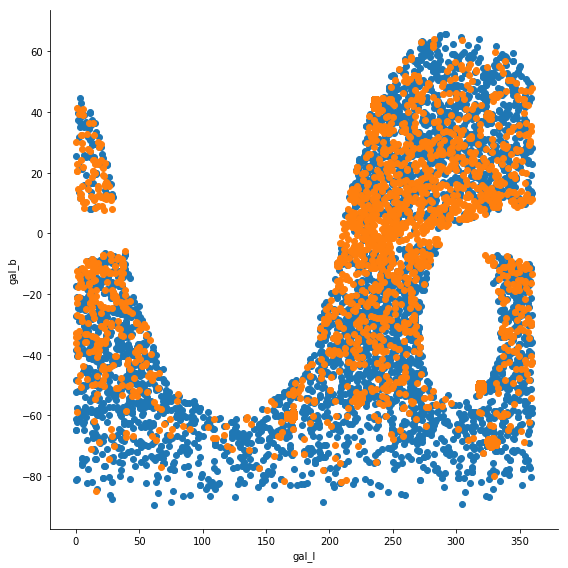

In [34]:
g = sns.FacetGrid(train_meta, hue = 'Milky.Way',size=8)
g.map(plt.scatter, 'gal_l','gal_b')

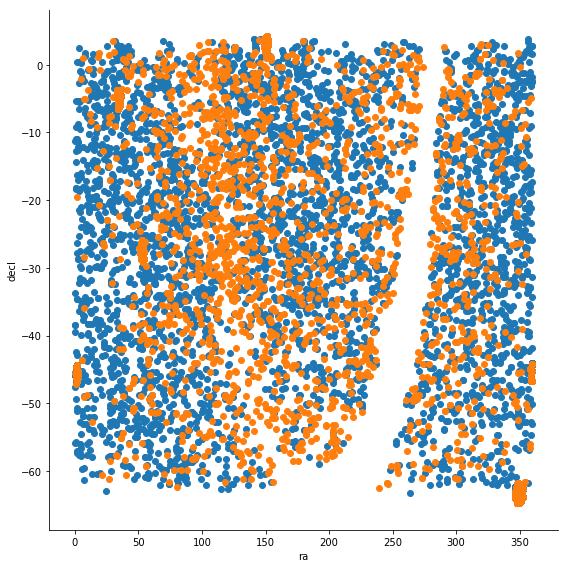

In [35]:
g = sns.FacetGrid(train_meta, hue = 'Milky.Way',size=8)
g.map(plt.scatter, 'ra','decl')

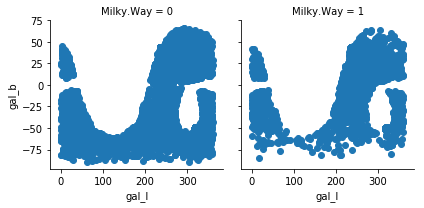

In [36]:
g = sns.FacetGrid(train_meta, col = 'Milky.Way',col_wrap=2)
g.map(plt.scatter, 'gal_l','gal_b')

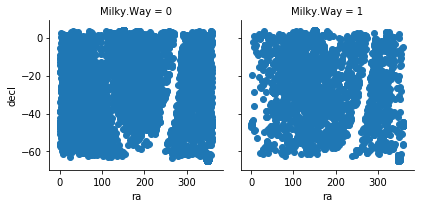

In [37]:
g = sns.FacetGrid(train_meta, col = 'Milky.Way',col_wrap=2)
g.map(plt.scatter, 'ra','decl')

In [38]:
print("Milky.Way is 0 of Target:",train_meta[train_meta['Milky.Way']==0]['target'].unique(),"\nMilky.Way is 1 of Target:",train_meta[train_meta['Milky.Way']==1]['target'].unique())

Milky.Way is 0 of Target: [88 42 90 67 95 62 15 52 64] 
Milky.Way is 1 of Target: [92 65 16  6 53]


### Train File Column Descriptions

In [39]:
train.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


- object id: Same key as in the metadata table abov.
- mjd: the time in Modified Julian Date (MJD) of the observation.
- passband: The specific LSST passband integer, such that u, g, r, i, z, y = 0, 1, 2, 3, 4, 5 in which it was viewed.
- flux: the measured flux (brightness) in the passband of observation as listed in the passband column. The flux is corrected for MWEBV.
- flux err: the uncertainty on the measurement of the flux listed above.
detected: If detected= 1, the object’s brightness is significantly different at the 3σ level relative to the reference template.

In [40]:
train.describe()

,object_id,mjd,passband,flux,flux_err,detected
count,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06
mean,3.392608e+07,6.017921e+04,2.783108e+00,2.468855e+01,2.548932e+01,1.666168e-01
std,4.258439e+07,3.092379e+02,1.703946e+00,3.684506e+03,3.814492e+03,3.726336e-01
min,6.150000e+02,5.958003e+04,0.000000e+00,-1.149388e+06,4.637530e-01,0.000000e+00
25%,1.843400e+05,5.989905e+04,1.000000e+00,-2.789418e+00,2.118670e+00,0.000000e+00
50%,4.548783e+06,6.019331e+04,3.000000e+00,7.331990e-01,4.708105e+00,0.000000e+00
75%,6.796280e+07,6.048722e+04,4.000000e+00,8.830932e+00,1.297371e+01,0.000000e+00
max,1.307798e+08,6.067436e+04,5.000000e+00,2.432809e+06,2.234069e+06,1.000000e+00


In [41]:
train['object_id'] = train['object_id'].astype(np.object)
train_meta['object_id'] = train_meta['object_id'].astype(np.object)

In [42]:
train['object_id'].head()

0    615
1    615
2    615
3    615
4    615
Name: object_id, dtype: object

In [43]:
train_all = train_meta.merge(train, how='left', on='object_id')

In [44]:
train_all.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,skycoordinate_y,skycoordinate_z,galatic_x,galatic_y,galatic_z,mjd,passband,flux,flux_err,detected
0,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59750.4229,2,-544.810303,3.622952,1
1,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59750.4306,1,-816.434326,5.553370,1
2,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59750.4383,3,-471.385529,3.801213,1
3,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59750.4450,4,-388.984985,11.395031,1
4,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59752.4070,2,-681.858887,4.041204,1


In [45]:
train_all.shape

(1421705, 24)

In [46]:
del train, train_meta
gc.collect()

8970

In [47]:
train_all['mjd'].head()

0    59750.4229
1    59750.4306
2    59750.4383
3    59750.4450
4    59752.4070
Name: mjd, dtype: float64

In [48]:
train_all['date'] = pd.to_datetime((train_all['mjd']-40587)*86400,unit='s')

In [49]:
train_all.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,skycoordinate_z,galatic_x,galatic_y,galatic_z,mjd,passband,flux,flux_err,detected,date
0,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,59750.4229,2,-544.810303,3.622952,1,2022-06-20 10:08:58.560
1,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,59750.4306,1,-816.434326,5.553370,1,2022-06-20 10:20:03.840
2,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,59750.4383,3,-471.385529,3.801213,1,2022-06-20 10:31:09.120
3,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,59750.4450,4,-388.984985,11.395031,1,2022-06-20 10:40:48.000
4,615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,59752.4070,2,-681.858887,4.041204,1,2022-06-22 09:46:04.800


In [50]:
train_all['target'].unique()

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

In [51]:
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
# import plotly.figure_factory as ff
# import random

# #https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-xgb
# def generate_color():
#     color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
#     return color
# for i in [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]:
    
#     data = []
#     for j in [0,1,2,3,4,5]:
#         j = go.Scatter(
#                 x = train_all[(train_all['target']==i)]['date'].dt.strftime(date_format='%Y-%m-%d').values,
#                 y = train_all[(train_all['target']==i) & (train_all['passband']==j)]['flux'].values,
#                 line = dict(color = generate_color()),opacity = 0.8
#             )

#         data.append(j)
                    
#     layout = dict(title = "Target {}".format(i),
#                           xaxis = dict(title = 'date'),
#                           yaxis = dict(title = 'flux'),
#                           )
#     py.iplot(dict(data=data, layout=layout), filename='basic-line')

If you click the trace on the upper right, you can see more better.

Text(0.5,1,'5')

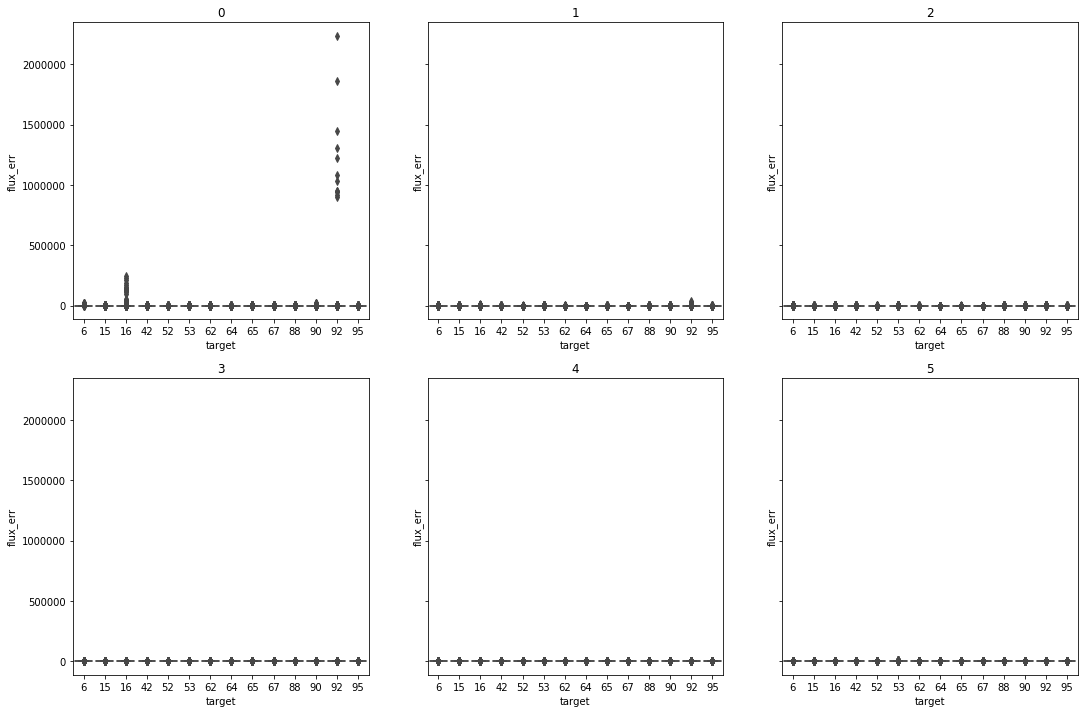

In [52]:
fig, (axes) = plt.subplots(2,3,figsize=(18,12),sharey=True)
sns.boxplot(x='target', y="flux_err", data=train_all[train_all['passband']==0],ax=axes[0,0])
axes[0,0].set_title('0')
sns.boxplot(x='target', y="flux_err", data=train_all[train_all['passband']==1],ax=axes[0,1])
axes[0,1].set_title('1')
sns.boxplot(x='target', y="flux_err", data=train_all[train_all['passband']==2],ax=axes[0,2])
axes[0,2].set_title('2')
sns.boxplot(x='target', y="flux_err", data=train_all[train_all['passband']==3],ax=axes[1,0])
axes[1,0].set_title('3')
sns.boxplot(x='target', y="flux_err", data=train_all[train_all['passband']==4],ax=axes[1,1])
axes[1,1].set_title('4')
sns.boxplot(x='target', y="flux_err", data=train_all[train_all['passband']==5],ax=axes[1,2])
axes[1,2].set_title('5')

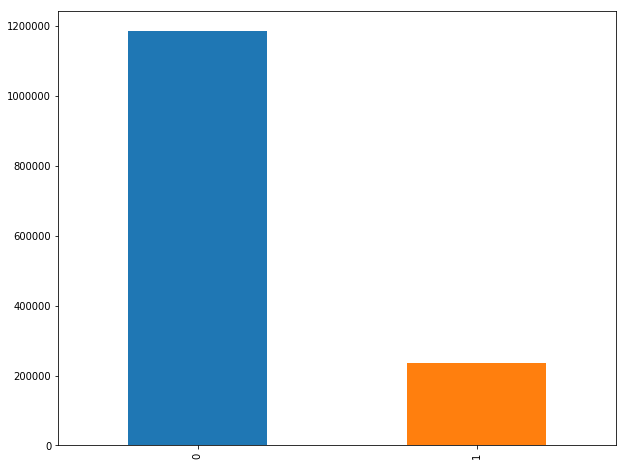

In [53]:
f, ax = plt.subplots(figsize=(10,8))
train_all['detected'].value_counts().sort_values(ascending=False).plot.bar()
plt.show()

Text(0.5,1,'detected : 1 & ddf : 1')

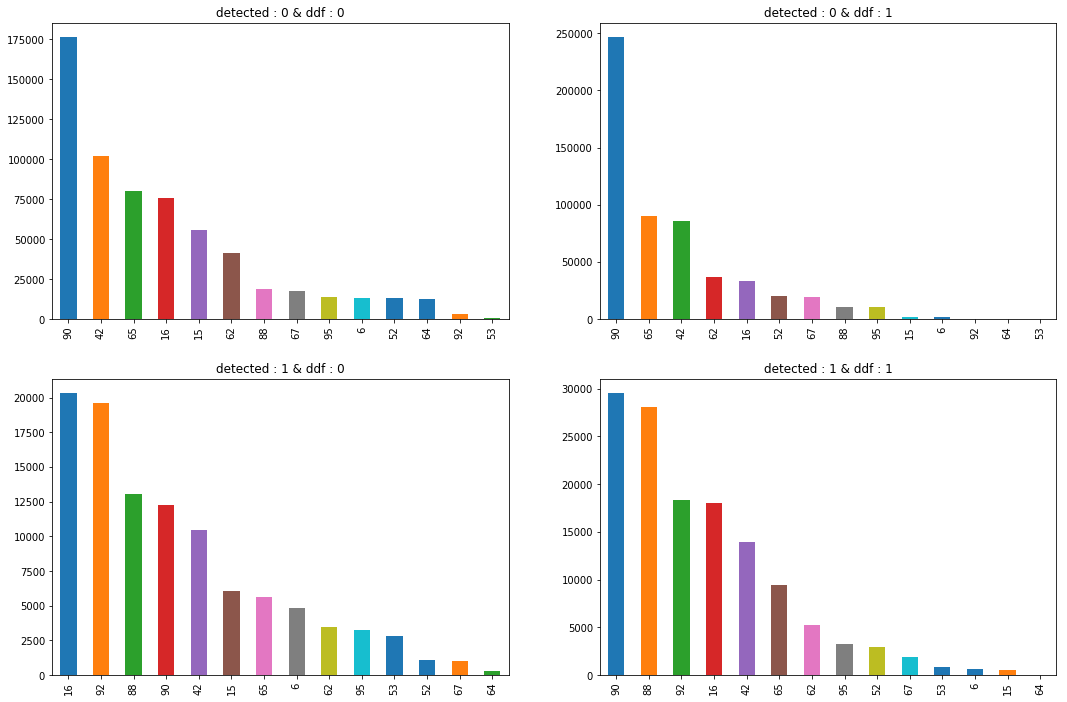

In [54]:
fig, (axes) = plt.subplots(2,2,figsize=(18,12))
ax1 = plt.subplot(2,2,1)
train_all[(train_all['detected']==0) & (train_all['ddf']==0)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 0 & ddf : 0')
ax1 = plt.subplot(2,2,2)
train_all[(train_all['detected']==0) & (train_all['ddf']==1)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 0 & ddf : 1')
ax1 = plt.subplot(2,2,3)
train_all[(train_all['detected']==1) & (train_all['ddf']==0)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 1 & ddf : 0')
ax1 = plt.subplot(2,2,4)
train_all[(train_all['detected']==1) & (train_all['ddf']==1)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 1 & ddf : 1')

Text(0.5,1,'detected : 1 & Milky.Way : 1')

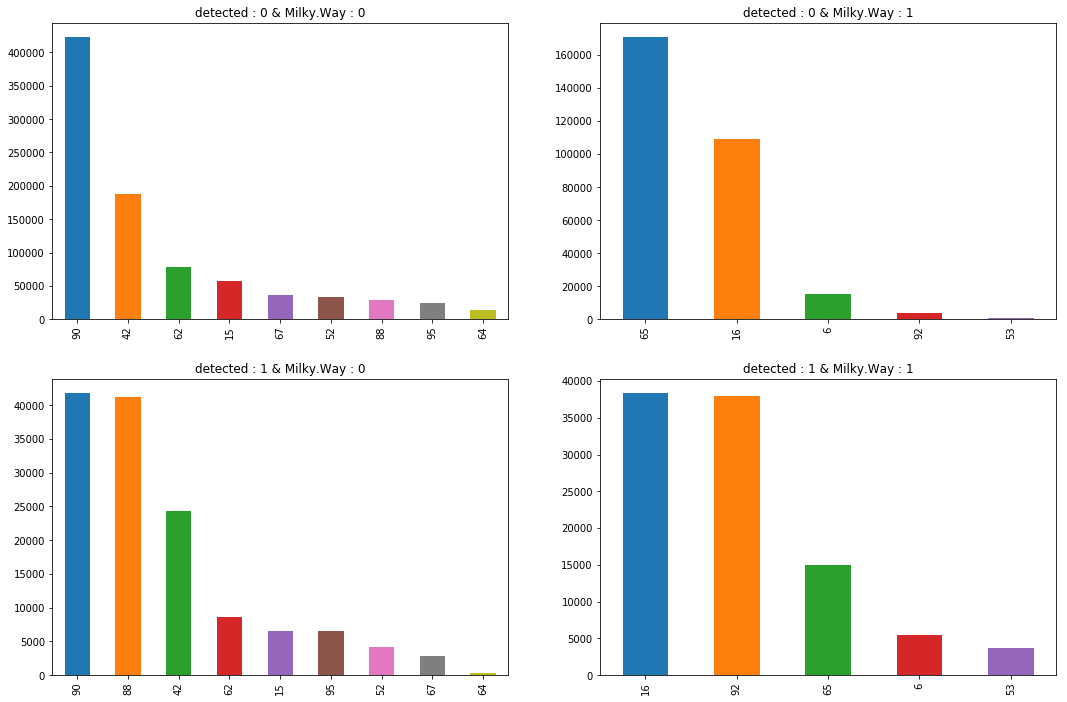

In [55]:
fig, (axes) = plt.subplots(2,2,figsize=(18,12))
ax1 = plt.subplot(2,2,1)
train_all[(train_all['detected']==0) & (train_all['Milky.Way']==0)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 0 & Milky.Way : 0')
ax1 = plt.subplot(2,2,2)
train_all[(train_all['detected']==0) & (train_all['Milky.Way']==1)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 0 & Milky.Way : 1')
ax1 = plt.subplot(2,2,3)
train_all[(train_all['detected']==1) & (train_all['Milky.Way']==0)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 1 & Milky.Way : 0')
ax1 = plt.subplot(2,2,4)
train_all[(train_all['detected']==1) & (train_all['Milky.Way']==1)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('detected : 1 & Milky.Way : 1')

Text(0.5,1,'ddf : 1 & Milky.Way : 1')

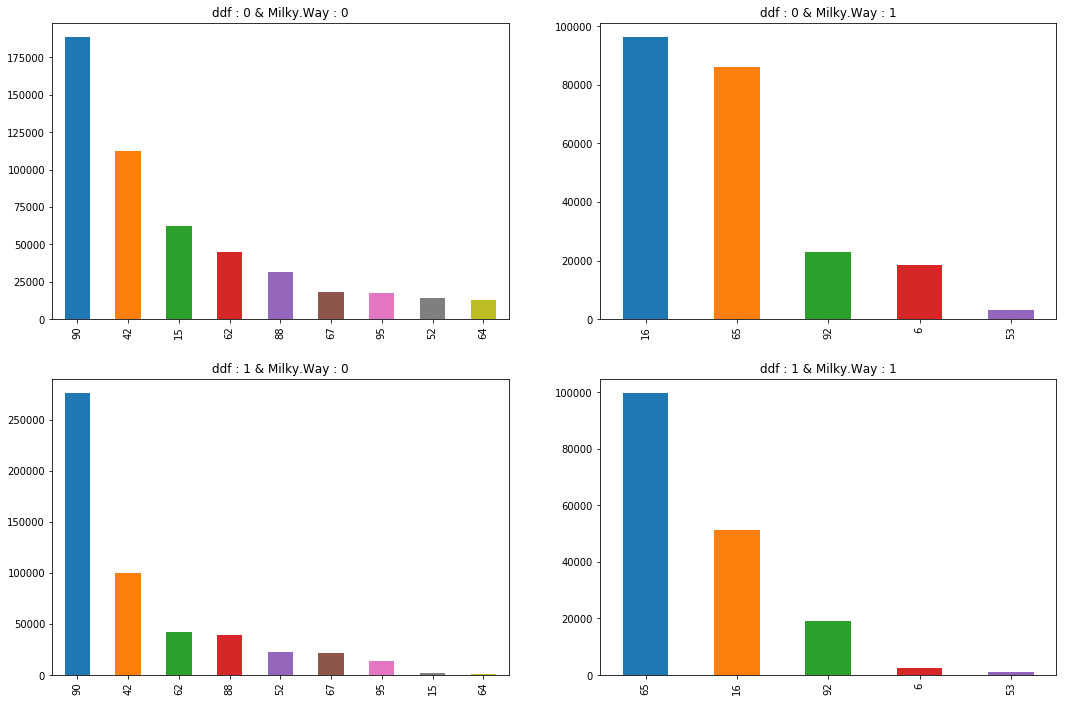

In [56]:
fig, (axes) = plt.subplots(2,2,figsize=(18,12))
ax1 = plt.subplot(2,2,1)
train_all[(train_all['ddf']==0) & (train_all['Milky.Way']==0)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('ddf : 0 & Milky.Way : 0')
ax1 = plt.subplot(2,2,2)
train_all[(train_all['ddf']==0) & (train_all['Milky.Way']==1)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('ddf : 0 & Milky.Way : 1')
ax1 = plt.subplot(2,2,3)
train_all[(train_all['ddf']==1) & (train_all['Milky.Way']==0)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('ddf : 1 & Milky.Way : 0')
ax1 = plt.subplot(2,2,4)
train_all[(train_all['ddf']==1) & (train_all['Milky.Way']==1)]['target'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('ddf : 1 & Milky.Way : 1')

## https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo

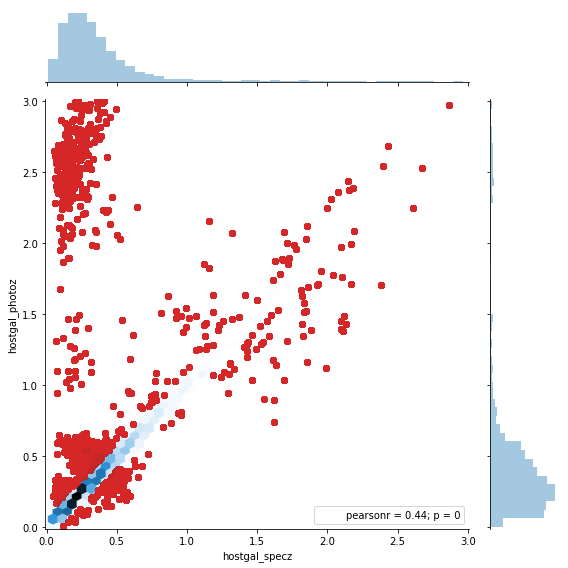

In [57]:
extragal = train_all['hostgal_specz'] != 0.
g = sns.jointplot(train_all['hostgal_specz'][extragal],\
              train_all['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), size=8)

outliers = np.abs(train_all['hostgal_specz'] - train_all['hostgal_photoz']) > 0.1
fig = g.fig
fig.axes[0].scatter(train_all['hostgal_specz'][outliers],\
                    train_all['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

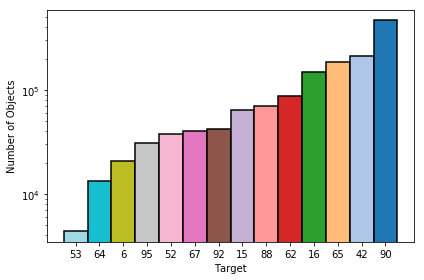

In [58]:
from operator import itemgetter
from collections import Counter

counts = Counter(train_all['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

In [59]:
from collections import Counter, OrderedDict

pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [62]:
from astropy.table import Table
from collections import Counter, OrderedDict
from tqdm import tnrange, tqdm_notebook
from cesium.time_series import TimeSeries
import os
import multiprocessing
import cesium.featurize as featurize
# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

In [63]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [64]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [65]:
def build_timeseries(metafile, file, feature_file):
    #datadir = '../input/plasticc-astronomy-starter-kit-media'
    #metafilename = '../input/training_set_metadata.csv'
    metafilename = metafile
    metadata = Table.read(metafilename, format='csv')
    nobjects = len(metadata)
    metadata

    #lcfilename = '../input/training_set.csv'
    lcfilename = file
    lcdata = Table.read(lcfilename, format='csv')
    lcdata
    tsdict = OrderedDict()

    for i in tnrange(nobjects, desc='Building Timeseries'):
        row = metadata[i]
        thisid = row['object_id']
        target = row['target']

        meta = {'z':row['hostgal_photoz'],\
                'zerr':row['hostgal_photoz_err'],\
                'mwebv':row['mwebv']}

        ind = (lcdata['object_id'] == thisid)
        thislc = lcdata[ind]

        pbind = [(thislc['passband'] == pb) for pb in pbmap]
        t = [thislc['mjd'][mask].data for mask in pbind ]
        m = [thislc['flux'][mask].data for mask in pbind ]
        e = [thislc['flux_err'][mask].data for mask in pbind ]

        tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                            label=target, name=thisid, meta_features=meta,\
                            channel_names=pbnames )
        
    if os.path.exists(featurefile):
        featuretable, _ = featurize.load_featureset(featurefile)
    else:
        features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with multiprocessing.Pool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)
    old_names = featuretable.columns.values
    new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
    cols = [featuretable[col] for col in old_names]
    allfeats = Table(cols, names=new_names)

#del lcdata

In [68]:
metafn = "training_set_metadata.csv"
fn = "training_set.csv"
featurefile = f'plasticc_featuretable_train.npz'

build_timeseries(metafn, fn, featurefile)

HBox(children=(IntProgress(value=0, description='Building Timeseries', max=7848), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Computing Features', max=7848), HTML(value='')))

UnboundLocalError: local variable 'features_list' referenced before assignment

In [67]:
df=allfeats.to_pandas()
df.head()

NameError: name 'allfeats' is not defined

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

In [ ]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

In [ ]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [ ]:
from sklearn.decomposition import PCA

ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')

clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

In [ ]:
### test data
metafn = "../input/test_set_metadata.csv"
fn = "../input/test_set.csv"
featurefile = f'plasticc_featuretable_test.npz'

build_timeseries(metafn, fn, featurefile)

In [ ]:
df=allfeats.to_pandas()
df.head()

In [ ]:
df.drop("object_id", axis=1)


In [ ]:
y_predicted_prob = clf.predict_proba(df)

In [ ]:
y_predicted_prob = clf.predict_proba(Xtest_pca)

In [ ]:
y_predicted_prob.shape

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

In [ ]:
print (accuracy_score(Ytest, Ypred))
print (classification_report(Ytest, Ypred))

In [ ]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [ ]:
object_id = np.array(metadata['object_id'][test_ind].tolist())
object_id
object_id.shape

In [ ]:
targets = np.hstack([Ypred])
Ytest

In [ ]:
test_df = pd.DataFrame(data=y_predicted_prob, columns=['class_%d' % i for i in labels])

In [ ]:
test_df['object_id']  = object_id
test_df = test_df.set_index('object_id').reset_index()
test_df['class_99'] = 1/np.sqrt(15)

In [ ]:
print(test_df.shape)
test_df.head(10)

In [ ]:
train_meta.dtypes

In [ ]:
test_df.dtypes
test_df['object_id'] = test_df['object_id'].astype(np.object)
test_df.dtypes

In [ ]:
#pred_all = pd.concat( train_meta, test_df)
#pred_all.head()



In [ ]:
test_df.to_csv('420Galaxy_Plastic Astronomical.csv', index = False)

In [ ]:
from subprocess import check_output
print(check_output(["ls", "../working"]).decode("utf8"))

## https://www.kaggle.com/kyleboone/naive-benchmark-galactic-vs-extragalactic

In [ ]:
meta_data = pd.read_csv('../input/training_set_metadata.csv')
test_meta_data = pd.read_csv('../input/test_set_metadata.csv')

In [ ]:
targets = np.hstack([np.unique(meta_data['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in meta_data['target']]
meta_data['target_id'] = target_ids

In [ ]:
galactic_cut = meta_data['hostgal_specz'] == 0
plt.figure(figsize=(10, 8))
plt.hist(meta_data[galactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Galactic')
plt.hist(meta_data[~galactic_cut]['target_id'], 15, (0, 15), alpha=0.5, label='Extragalactic')
plt.xticks(np.arange(15)+0.5, targets)
plt.gca().set_yscale("log")
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim(0, 15)
plt.legend();

In [ ]:
# Build the flat probability arrays for both the galactic and extragalactic groups
galactic_cut = meta_data['hostgal_specz'] == 0
galactic_data = meta_data[galactic_cut]
extragalactic_data = meta_data[~galactic_cut]

galactic_classes = np.unique(galactic_data['target_id'])
extragalactic_classes = np.unique(extragalactic_data['target_id'])

# Add class 99 (id=14) to both groups.
galactic_classes = np.append(galactic_classes, 14)
extragalactic_classes = np.append(extragalactic_classes, 14)

galactic_probabilities = np.zeros(15)
galactic_probabilities[galactic_classes] = 1. / len(galactic_classes)
extragalactic_probabilities = np.zeros(15)
extragalactic_probabilities[extragalactic_classes] = 1. / len(extragalactic_classes)

In [ ]:
# Apply this prediction to a table
import tqdm
def do_prediction(table):
    probs = []
    for index, row in tqdm.tqdm(table.iterrows(), total=len(table)):
        if row['hostgal_photoz'] == 0:
            prob = galactic_probabilities
        else:
            prob = extragalactic_probabilities
        probs.append(prob)
    return np.array(probs)

pred = do_prediction(meta_data)
test_pred = do_prediction(test_meta_data)

In [ ]:
test_df = pd.DataFrame(index=test_meta_data['object_id'], data=test_pred, columns=['class_%d' % i for i in targets])
test_df.to_csv('./naive_benchmark.csv')